### LightGBM hyperparameters tuning: Only Horizon 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import gc


In [3]:
final_train_df = pd.read_csv("/kaggle/input/vn1-horizon-1/train_df_1.csv")
final_test_df = pd.read_csv("/kaggle/input/vn1-horizon-1/test_df_1.csv")

In [5]:
final_train_df['ds'] = pd.to_datetime(final_train_df['ds'])
final_test_df['ds'] = pd.to_datetime(final_test_df['ds'])

In [6]:
valid_date_min = pd.to_datetime("2023-04-01")
valid_date_max = final_train_df['ds'].max()

final_valid_df = final_train_df[(final_train_df['ds']<= valid_date_max) & (final_train_df['ds']>=valid_date_min)]
final_train_df = final_train_df[(final_train_df['ds']< valid_date_min)]

x_train= final_train_df.copy()
x_train.drop(columns = ['ds'], inplace= True)
x_train.drop(columns=['y'], inplace= True)
y_train = final_train_df['y']

x_valid= final_valid_df.copy()
x_valid.drop(columns = ['ds'], inplace= True)
x_valid.drop(columns=['y'], inplace= True)
y_valid = final_valid_df['y']


x_test= final_test_df.copy()
x_test.drop(columns = ['ds'], inplace= True)
x_test.drop(columns=['y'], inplace= True)
y_test = final_test_df['y']

print("Train data shape", x_train.shape, y_train.shape)
print("Valid data shape", x_valid.shape, y_valid.shape)
print("Test data shape", x_test.shape, y_test.shape)

Train data shape (2152579, 69) (2152579,)
Valid data shape (406431, 69) (406431,)
Test data shape (195689, 69) (195689,)


In [7]:
model = lgb.LGBMRegressor(device = 'gpu', first_metric_only = True)

model.fit(x_train, y_train,
          eval_metric = 'l1', 
          eval_set = [(x_valid, y_valid)]
          )

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 14653
[LightGBM] [Info] Number of data points in the train set: 2152579, number of used features: 67
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 23 dense feature groups (49.27 MB) transferred to GPU in 0.048098 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 11.789856


LGBMRegressor(device='gpu', first_metric_only=True)

In [8]:
id_cols = ['Client', 'Warehouse', 'Product']

In [9]:
# Custom error metric 
def custom_error(true, pred):
        
    abs_err = np.nansum(np.abs(pred - true))
    err = np.nansum((pred - true))
    score = abs_err + abs(err)
    score /= true.sum().sum()
    return score

In [10]:
forecast = model.predict(x_test)

cerr_mod = custom_error(final_test_df['y'], forecast)
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - final_test_df['y']))))

print('Custom error')
print('  LightGBM MAE: %.4f' % cerr_mod)


  LightGBM MAE: 7.6651
Custom error
  LightGBM MAE: 0.4125


### Hyperparameter Tuning¶

1. Number of Trees¶


 10 --- MAE: -8.507 (0.075)
 50 --- MAE: -3.610 (0.067)
100 --- MAE: -3.432 (0.069)
500 --- MAE: -3.228 (0.063)
1000 --- MAE: -3.146 (0.064)
2000 --- MAE: -3.087 (0.065)


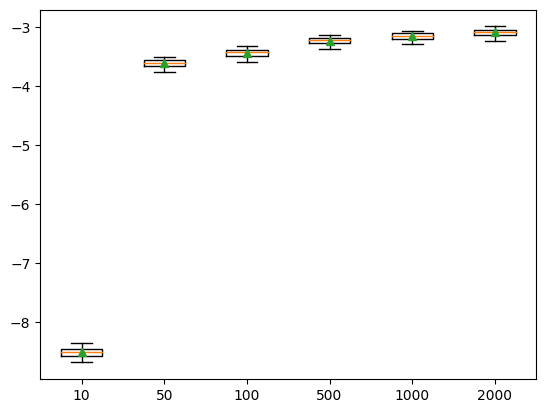

In [12]:
trees = [10, 50, 100, 500, 1000, 2000]

results = []
names = []
for i in trees:
    
    params = {
        'n_estimators': i,
        'device': 'gpu'
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), x_train, y_train, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%3d --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

#### 2.Tree Depth

In [ ]:

results = []
names = []
for i in range(1, 11):
    
    params = {
        'max_depth': i,
        'num_leaves': 2**i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), x_train, y_train, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%3d --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

#### 3. Learning Rate

In [ ]:

rates = [0.0001, 0.001, 0.01, 0.1, 1.0]

results = []
names = []
for i in rates:
    
    params = {
        'learning_rate': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), x_train, y_train, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%.3f --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

#### 4. Boosting Type
gbdt: Gradient Boosting Decision Tree (GDBT).

dart: Dropouts meet Multiple Additive Regression Trees (DART).

goss: Gradient-based One-Side Sampling (GOSS).


In [ ]:

types = ['gbdt', 'dart', 'goss']

results = []
names = []
for i in types:
    
    params = {
        'boosting_type': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), x_train, y_train, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%s --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()